
# Bias Audit Report Notebook (IBM AIF360 + Jupyter)

This notebook lets you:
- Paste **single pieces of text** to flag potential bias indicators (identity terms, slurs, gendered language, sentiment tilt).
- Audit a **dataset** with a protected attribute column using **IBM AI Fairness 360 (AIF360)**.
- Train a quick baseline classifier and compute fairness metrics like **Statistical Parity Difference**, **Disparate Impact**, **Equal Opportunity Difference**, and **Average Odds Difference**.
- Try a simple **mitigation** (Reweighing) and compare metrics.

> **Expected dataset format (CSV)**:  
> - `text` *(string)* — the content to analyze  
> - `protected_attribute` *(string or int)* — e.g., `female` vs `male`, or `0` vs `1`  
> - `label` *(optional, 0/1 or string convertible to 0/1)* — the ground-truth outcome if you're auditing a predictive task  
>
> You can run the *single-text audit* without any dataset. For fairness metrics you’ll need `label` and `protected_attribute`.


In [60]:

# If running on a fresh environment, install dependencies (uncomment if needed).
# You can skip if you already have these installed.
# Note: Some environments require restart after installs.

# !pip install --quiet aif360==0.6.1 scikit-learn pandas numpy matplotlib nltk imbalanced-learn


In [61]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Ensure VADER lexicon is available
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    import nltk
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

pd.options.display.max_colwidth = 200


In [62]:

IDENTITY_TERMS = {
    "gender": [
        "woman","women","female","man","men","male","girl","boy","guys","ladies",
        "trans","transgender","nonbinary","genderqueer","she","her","hers","he","him","his","they","them","theirs"
    ],
    "race_ethnicity": [
        "black","white","asian","latino","latina","hispanic","indian","middle eastern","arab",
        "african","european","native","indigenous"
    ],
    "religion": [
        "christian","muslim","islamic","jewish","jew","hindu","buddhist","sikh","atheist"
    ],
    "orientation": [
        "gay","lesbian","bisexual","queer","lgbt","lgbtq","straight","heterosexual"
    ],
    "age": [
        "old","elderly","youth","young","teen","teenage","senior","middle-aged"
    ]
}

# Example slur/offensive lexicon (very minimal & non-exhaustive; augment for production)
SLURS = [
    # This list is intentionally minimal. For production, use vetted, community-reviewed resources.
    "idiot","stupid","dumb","retarded","moron"
]

GENDERED_PHRASES = [
    # Stereotype-y phrases (illustrative only)
    "man up","like a girl","boys will be boys","hysterical woman"
]

def contains_any(text, terms):
    t = text.lower()
    hits = []
    for w in terms:
        if re.search(r'\b' + re.escape(w) + r'\b', t):
            hits.append(w)
    return hits

def text_bias_flags(text: str):
    flags = {}

    # Identity mentions
    id_hits = {}
    for k, vocab in IDENTITY_TERMS.items():
        hits = contains_any(text, vocab)
        if hits:
            id_hits[k] = hits
    if id_hits:
        flags['identity_mentions'] = id_hits

    # Slurs/offensive
    slur_hits = contains_any(text, SLURS)
    if slur_hits:
        flags['offensive_terms'] = slur_hits

    # Gendered phrases
    gp_hits = contains_any(text, GENDERED_PHRASES)
    if gp_hits:
        flags['gendered_phrases'] = gp_hits

    # Sentiment
    s = sia.polarity_scores(text)
    flags['sentiment'] = s

    # Polarity tilt (simple heuristic): very negative with identity mention
    if 'identity_mentions' in flags and s['compound'] <= -0.5:
        flags['note'] = "Strong negative sentiment co-occurs with identity mentions. Review for potential bias."

    return flags



## 🔎 Single-Text Bias Scan
Paste text into `sample_text` and run the cell to see flags.


In [63]:

sample_text = """That candidate is too emotional; he should just man up."""

flags = text_bias_flags(sample_text)
flags


{'identity_mentions': {'gender': ['man', 'he']},
 'gendered_phrases': ['man up'],
 'sentiment': {'neg': 0.0, 'neu': 0.849, 'pos': 0.151, 'compound': 0.1531}}


## 📁 Load a Dataset
Set `csv_path` to your file. Required columns:
- `text`
- `protected_attribute`
- `label` *(optional for fairness metrics; needed if training a model)*


In [64]:

# Example:
csv_path = "my_dataset.csv"  

df = pd.read_csv(csv_path)
print("Rows:", len(df))
df.head()


Rows: 30


,text,protected_attribute,label
0,"I love this product, it works great!",female,positive
1,This service was excellent and very helpful.,male,positive
2,I am very satisfied with the results.,female,positive
3,"Fantastic experience, would recommend.",male,positive
4,This app is amazing and easy to use.,female,positive



## 🧭 Dataset Overview & Representation
This section inspects representation per group and runs a light text scan per group.


In [65]:

assert 'text' in df.columns and 'protected_attribute' in df.columns, "Dataset must have 'text' and 'protected_attribute' columns."

# Normalize protected attribute to string
df['protected_attribute'] = df['protected_attribute'].astype(str)

# If label exists, try to convert to {0,1}
has_label = 'label' in df.columns
if has_label:
    # Auto-encode to 0/1 if needed
    if df['label'].dtype != np.number:
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'].astype(str))

group_counts = df['protected_attribute'].value_counts(dropna=False)
group_prop = (group_counts / len(df)).rename("proportion")
rep = pd.concat([group_counts.rename("count"), group_prop], axis=1)
rep


,count,proportion
protected_attribute,,
female,17,0.566667
male,13,0.433333


In [66]:

def quick_group_scan(df, max_per_group=200):
    rows = []
    for g, sub in df.groupby('protected_attribute'):
        sub_s = sub.sample(min(len(sub), max_per_group), random_state=42)
        identity_hits = 0
        offensive_hits = 0
        gendered_hits = 0
        neg_with_identity = 0

        for txt in sub_s['text'].astype(str).tolist():
            f = text_bias_flags(txt)
            identity_hits += int('identity_mentions' in f)
            offensive_hits += int('offensive_terms' in f)
            gendered_hits += int('gendered_phrases' in f)
            if 'identity_mentions' in f and f['sentiment']['compound'] <= -0.5:
                neg_with_identity += 1

        n = len(sub_s)
        rows.append({
            'group': g,
            'n_scanned': n,
            'pct_identity_mentions': identity_hits / n if n else np.nan,
            'pct_offensive_terms': offensive_hits / n if n else np.nan,
            'pct_gendered_phrases': gendered_hits / n if n else np.nan,
            'pct_neg_sentiment_with_identity': neg_with_identity / n if n else np.nan
        })
    return pd.DataFrame(rows).sort_values('group')

scan_summary = quick_group_scan(df)
scan_summary


,group,n_scanned,pct_identity_mentions,pct_offensive_terms,pct_gendered_phrases,pct_neg_sentiment_with_identity
0,female,17,0.0,0.0,0.0,0.0
1,male,13,0.0,0.0,0.0,0.0



## 🤖 Train a Simple Classifier (if `label` exists) & Compute Fairness Metrics
We train a TF‑IDF + Logistic Regression baseline and evaluate fairness with AIF360.


Model report (test):
              precision    recall  f1-score   support

           0      0.333     1.000     0.500         3
           1      0.000     0.000     0.000         3
           2      0.000     0.000     0.000         3

    accuracy                          0.333         9
   macro avg      0.111     0.333     0.167         9
weighted avg      0.111     0.333     0.167         9

ROC AUC unavailable: multi_class must be in ('ovo', 'ovr')
{'unprivileged_group': 'male', 'privileged_group': 'female', 'statistical_parity_difference': np.float64(0.0), 'disparate_impact': np.float64(1.0), 'equal_opportunity_difference': np.float64(0.0), 'average_odds_difference': np.float64(0.0)}


c:\Users\Angelique.Hilario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Angelique.Hilario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Angelique.Hilario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

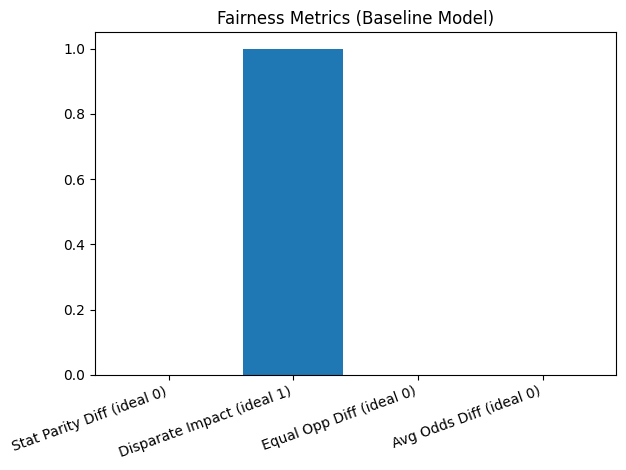

In [67]:

if has_label:
    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        df['text'].astype(str), df['label'].astype(int), df['protected_attribute'].astype(str),
        test_size=0.3, random_state=42, stratify=df['label']
    )

    vect = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
    Xtr = vect.fit_transform(X_train)
    Xte = vect.transform(X_test)

    clf = LogisticRegression(max_iter=200, n_jobs=None)
    clf.fit(Xtr, y_train)
    proba = clf.predict_proba(Xte)[:,1]
    pred = (proba >= 0.5).astype(int)

    print("Model report (test):")
    print(classification_report(y_test, pred, digits=3))
    try:
        print("ROC AUC:", roc_auc_score(y_test, proba))
    except Exception as e:
        print("ROC AUC unavailable:", e)

    # Prepare AIF360 dataset objects
    # Choose an unprivileged and privileged group from the most common values in g_test
    group_vals = pd.Series(g_test).value_counts().index.tolist()
    if len(group_vals) < 2:
        raise ValueError("Need at least two groups in 'protected_attribute' to compute fairness metrics.")
    unpriv = group_vals[-1]
    priv = group_vals[0]

    # Binarize y_test for AIF360 (e.g., map label==0 to 0, label>0 to 1)
    y_test_bin = (y_test > 0).astype(int)

    # Use binarized labels for AIF360
    test_df_for_aif = pd.DataFrame({
        'label': y_test_bin.values,
        'protected_attribute': g_test.values,
        'y_pred': pred
    })

    # Map groups to binary protected attribute for AIF360
    pa_bin = (test_df_for_aif['protected_attribute'] == priv).astype(int)
    
    dataset_true = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame({'label': test_df_for_aif['label'].values, 'pa': pa_bin.values}),
        label_names=['label'],
        protected_attribute_names=['pa']
    )

    dataset_pred = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame({'label': test_df_for_aif['y_pred'].values, 'pa': pa_bin.values}),
        label_names=['label'],
        protected_attribute_names=['pa']
    )

    bld_metric = BinaryLabelDatasetMetric(
        dataset_true,
        privileged_groups=[{'pa': 1}],
        unprivileged_groups=[{'pa': 0}]
    )

    clf_metric = ClassificationMetric(
        dataset_true,
        dataset_pred,
        privileged_groups=[{'pa': 1}],
        unprivileged_groups=[{'pa': 0}]
    )

    spd = bld_metric.statistical_parity_difference()
    di = bld_metric.disparate_impact()
    eod = clf_metric.equal_opportunity_difference()
    aod = clf_metric.average_odds_difference()

    print({
        "unprivileged_group": unpriv,
        "privileged_group": priv,
        "statistical_parity_difference": spd,
        "disparate_impact": di,
        "equal_opportunity_difference": eod,
        "average_odds_difference": aod
    })

    # Plot metrics (one plot only; default colors)
    metrics = ["Stat Parity Diff (ideal 0)", "Disparate Impact (ideal 1)", "Equal Opp Diff (ideal 0)", "Avg Odds Diff (ideal 0)"]
    values = [spd, di, eod, aod]

    plt.figure()
    plt.bar(metrics, values)
    plt.xticks(rotation=20, ha='right')
    plt.title("Fairness Metrics (Baseline Model)")
    plt.tight_layout()
    plt.show()
else:
    print("No 'label' column detected. Skipping model + fairness metrics.")



## 🛠️ Mitigation: Reweighing (AIF360)
We apply **Reweighing** to the training data and retrain the model, then recompute metrics.


{'statistical_parity_difference': np.float64(0.0), 'disparate_impact': np.float64(1.0), 'equal_opportunity_difference': np.float64(-0.5), 'average_odds_difference': np.float64(-0.5)}


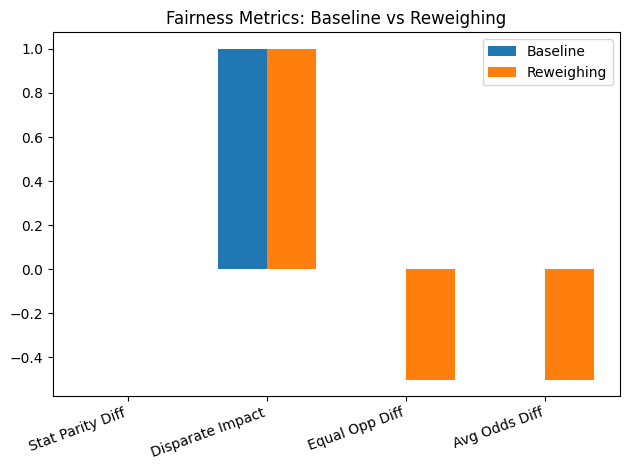

In [68]:
if has_label:
    # Build train dataset with protected attribute binary
    g_train_series = pd.Series(g_train)
    priv = g_train_series.value_counts().index[0]
    pa_bin_train = (g_train_series == priv).astype(int)

    # Only keep binary labels (0=negative, 1=neutral, 2=positive)
    # For fairness, map 2->1 (favorable), 0->0 (unfavorable), drop 1 (neutral)
    y_train_bin = y_train[y_train != 1].map({0: 0, 2: 1})
    pa_bin_train_bin = pa_bin_train[y_train != 1]

    y_test_bin = y_test[y_test != 1].map({0: 0, 2: 1})
    pa_bin_test_bin = (g_test[y_test != 1] == priv).astype(int)

    train_df_for_aif = pd.DataFrame({'label': y_train_bin.values, 'pa': pa_bin_train_bin.values})
    test_df_for_aif_bin = pd.DataFrame({'label': y_test_bin.values, 'pa': pa_bin_test_bin.values})

    train_bld = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=train_df_for_aif,
        label_names=['label'],
        protected_attribute_names=['pa']
    )

    reweigh = Reweighing(
        privileged_groups=[{'pa': 1}],
        unprivileged_groups=[{'pa': 0}]
    )
    reweigh.fit(train_bld)
    train_bld_rw = reweigh.transform(train_bld)

    # Use instance weights during training
    # Align weights order with X_train rows
    weights = pd.Series(train_bld_rw.instance_weights).values

    vect_rw = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
    Xtr_rw = vect_rw.fit_transform(X_train)
    Xte_rw = vect_rw.transform(X_test)

    # Filter Xtr_rw and y_train to match the filtered indices (y_train != 1)
    train_mask = (y_train != 1).values  # Convert pandas Series to numpy array
    Xtr_rw_bin = Xtr_rw[train_mask]
    y_train_bin_arr = y_train_bin.values  # already filtered above

    clf_rw = LogisticRegression(max_iter=200)
    clf_rw.fit(Xtr_rw_bin, y_train_bin_arr, sample_weight=weights)

    proba_rw = clf_rw.predict_proba(Xte_rw)[:,1]
    pred_rw = (proba_rw >= 0.5).astype(int)

    # Recompute metrics
    test_df_for_aif_rw = pd.DataFrame({
        'label': y_test.values,
        'protected_attribute': g_test.values,
        'y_pred': pred_rw
    })
    pa_bin_test_rw = (test_df_for_aif_rw['protected_attribute'] == priv).astype(int)

    # Only keep binary labels (0=unfavorable, 2=favorable), map 2->1, drop 1 (neutral)
    mask_bin = test_df_for_aif_rw['label'] != 1
    label_bin = test_df_for_aif_rw.loc[mask_bin, 'label'].map({0: 0, 2: 1})
    pa_bin = pa_bin_test_rw[mask_bin].values
    y_pred_bin = test_df_for_aif_rw.loc[mask_bin, 'y_pred'].values

    dataset_true_rw = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame({'label': label_bin.values, 'pa': pa_bin}),
        label_names=['label'],
        protected_attribute_names=['pa']
    )
    dataset_pred_rw = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame({'label': y_pred_bin, 'pa': pa_bin}),
        label_names=['label'],
        protected_attribute_names=['pa']
    )

    bld_metric_rw = BinaryLabelDatasetMetric(
        dataset_true_rw,
        privileged_groups=[{'pa': 1}],
        unprivileged_groups=[{'pa': 0}]
    )
    clf_metric_rw = ClassificationMetric(
        dataset_true_rw,
        dataset_pred_rw,
        privileged_groups=[{'pa': 1}],
        unprivileged_groups=[{'pa': 0}]
    )

    spd_rw = bld_metric_rw.statistical_parity_difference()
    di_rw = bld_metric_rw.disparate_impact()
    eod_rw = clf_metric_rw.equal_opportunity_difference()
    aod_rw = clf_metric_rw.average_odds_difference()

    print({
        "statistical_parity_difference": spd_rw,
        "disparate_impact": di_rw,
        "equal_opportunity_difference": eod_rw,
        "average_odds_difference": aod_rw
    })

    # Plot comparison
    metrics = ["Stat Parity Diff", "Disparate Impact", "Equal Opp Diff", "Avg Odds Diff"]
    base_vals = [spd, di, eod, aod]
    rw_vals = [spd_rw, di_rw, eod_rw, aod_rw]

    # One plot only per instruction; show side-by-side bars by offsetting x positions
    x = np.arange(len(metrics))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, base_vals, width, label='Baseline')
    plt.bar(x + width/2, rw_vals, width, label='Reweighing')
    plt.xticks(x, metrics, rotation=20, ha='right')
    plt.title("Fairness Metrics: Baseline vs Reweighing")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No 'label' column detected. Skipping mitigation.")



## 🧾 Report Summary Helper
This cell prints a concise, copy‑pastable report from the computed artifacts.


In [69]:

def summarize_report(group_representation=None, scan_summary=None, baseline_metrics=None, mitigated_metrics=None):
    print("=== Bias Audit Report ===")
    if group_representation is not None:
        print("\n[Representation by protected group]\n")
        print(group_representation.to_string())

    if scan_summary is not None:
        print("\n[Group-wise Text Scan]\n")
        print(scan_summary.to_string(index=False))

    if baseline_metrics is not None:
        print("\n[Baseline Fairness Metrics]\n")
        for k,v in baseline_metrics.items():
            print(f"{k}: {v}")

    if mitigated_metrics is not None:
        print("\n[Mitigated Fairness Metrics]\n")
        for k,v in mitigated_metrics.items():
            print(f"{k}: {v}")
    print("\nNotes:")
    print("- Values near 0 for SPD/EOD/AOD and near 1 for DI indicate better parity.")
    print("- Review single-text flags for context & language cues not captured by model-level metrics.")

# Auto-prepare dicts if available
baseline_metrics = None
mitigated_metrics = None
try:
    baseline_metrics = {
        "statistical_parity_difference": spd,
        "disparate_impact": di,
        "equal_opportunity_difference": eod,
        "average_odds_difference": aod
    }
except NameError:
    pass

try:
    mitigated_metrics = {
        "statistical_parity_difference": spd_rw,
        "disparate_impact": di_rw,
        "equal_opportunity_difference": eod_rw,
        "average_odds_difference": aod_rw
    }
except NameError:
    pass

summarize_report(
    group_representation=rep if 'rep' in globals() else None,
    scan_summary=scan_summary if 'scan_summary' in globals() else None,
    baseline_metrics=baseline_metrics,
    mitigated_metrics=mitigated_metrics
)


=== Bias Audit Report ===

[Representation by protected group]

                     count  proportion
protected_attribute                   
female                  17    0.566667
male                    13    0.433333

[Group-wise Text Scan]

 group  n_scanned  pct_identity_mentions  pct_offensive_terms  pct_gendered_phrases  pct_neg_sentiment_with_identity
female         17                    0.0                  0.0                   0.0                              0.0
  male         13                    0.0                  0.0                   0.0                              0.0

[Baseline Fairness Metrics]

statistical_parity_difference: 0.0
disparate_impact: 1.0
equal_opportunity_difference: 0.0
average_odds_difference: 0.0

[Mitigated Fairness Metrics]

statistical_parity_difference: 0.0
disparate_impact: 1.0
equal_opportunity_difference: -0.5
average_odds_difference: -0.5

Notes:
- Values near 0 for SPD/EOD/AOD and near 1 for DI indicate better parity.
- Review single-tex